# ผลกระทบและปัจจัยการเกิดของ PM2.5
- Pm2.5คือฝุ่นที่ใครๆก็รู้จัก และพยายามจะแก้ไขด้วยหลายต่อหลายวิธี ด้วยการลดการใช้รถ ฉีดน้ำ สวดมนต์ วิ่งไล่และอีกหลายวิธี ทุกคนต่างคิดว่าถ้าเราลดการใช้หรือการเผาอาจจะทำให้ปริมาณฝุ่นลดลง แต่เคยสงสัยไหมว่า เราก็ใช้ชีวิตของเราตามปกติทั้งปี ขับรถไปทำงานทุกเช้าทุกวัน ทำไมถึงมีแค่ฝุ่นหนาบางช่วง หรือจริงๆแล้วเหตุที่ฝุ่นเยอะอาจจะมาจากปัจจัยอื่นด้วยที่คนมองข้าม พวกเราจึงได้ทำการดึงข้อมูลของฝุ่นแต่ล่ะประเทศออกมาเพื่อวิเคราะห์หาสาเหตุที่แท้จริง

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.ticker import MaxNLocator
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
%matplotlib inline
%config InlineBackend.figure_format='retina'

  function การสร้าง column DateTime และ column Date
 - ถ้าหากมีบางประเทศที่อยู่ใน list ที่ timezone เป็นลบ ให้ลบด้วยจำนวนชั่วโมงตาม time_zone
 - โดยดึงข้อมูล time_zone ที่มี key = ชื่อของ country

In [2]:
minus_UTC = ['Canada']

def create_date(df,time_zone,country): 
    #ถ้าข้อมูลที่ได้มาไม่มีข้อมูลชั่วโมงให้สร้างแค่ column date แต่ถ้ามีข้อมูลชั่วโมงให้นำชั่วโมงบวกตาม Timezone
    if 'Hour' in list(df.columns):
        if country in minus_UTC :
            df['DateTime']=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']]) - pd.to_timedelta(time_zone[country])
            df['Year']=df['DateTime'].dt.year
            df['Month']=df['DateTime'].dt.month
            df['Day']=df['DateTime'].dt.day
            df['Date']=pd.to_datetime(df[['Year', 'Month', 'Day']])
        else :
            df['DateTime']=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']]) + pd.to_timedelta(time_zone[country])
            df['Year']=df['DateTime'].dt.year
            df['Month']=df['DateTime'].dt.month
            df['Day']=df['DateTime'].dt.day
            df['Date']=pd.to_datetime(df[['Year', 'Month', 'Day']])
    else:
        df['Date']=pd.to_datetime(df[['Year', 'Month', 'Day']])
        df['Year']=df['Date'].dt.year
        df['Month']=df['Date'].dt.month
        df['Day']=df['Date'].dt.day
    return df

  function การgroup dataframe ด้วย column Date
 - used_column = column ที่ต้องการสร้างตาราง 
 - group_column = column ที่ต้องการ group
 - สร้าง column ym (year-month) และ column month

In [3]:
def group_date(df,used_column,group_column):
    df_group = df[used_column].groupby([group_column]).mean()
    df_group['ym'] = df_group.index.strftime('%Y-%m')
    df_group['month'] = df_group.index.strftime('%m')
    return df_group

 การสร้าง list แต่ละประเทศ ตามข้อมูล pm2.5
- urls = link ที่ต้องการดึงข้อมูล pm2.5 ของแต่ละประเทศ (เก็บเป็น dictation)
- time_zone = ข้อมูลเวลา utc ของแต่ละประเทศ 
- turn ค่าออกมาเป็น list ของ dataframe

In [4]:
col_names = 'Year, Month, Day, UTC Hour, PM2.5, PM10_mask, Retrospective'.split(', ')

#data source : http://berkeleyearth.lbl.gov/air-quality/CityPage.php
urls = {'Thailand':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/Bangkok/Bangkok.txt',
        'Japan':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Japan/Osaka/Osaka.txt',
        'China':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/China/China.txt',
        'Australia':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Australia/Victoria/Victoria.txt',
        'Korea':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/South_Korea/Seoul/Seoul.txt',
        'New_Zealand':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/New_Zealand/Wellington/Wellington.txt',
        'Canada':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Canada/Ontario/Ottawa.txt',
        'France':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/France/Ile-de-France/Paris.txt',
        'Turkey':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Turkey/Turkey.txt',
        'India':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/India/NCT/New_Delhi.txt',
        'Russian':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Russian_Federation/Moscow/Moscow.txt',
        'Belgium':'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Belgium/Belgium.txt'}

            
time_zone = {'Thailand':'7 hours',
             'Japan':'9 hours',
             'China':'8 hours',
             'Australia':'9 hours',
             'Korea':'9 hours',
             'New_Zealand':'12 hours',
             'Canada':'5 hours',
             'France':'1 hours',
             'Turkey':'3 hours',
             'India':'5 hours',
             'Russian':'0 hours',
             'Belgium':'1 hours'}

skip_rows = {'Thailand':10,'Japan':10,'China':10,'Australia':8,'Korea':10,'New_Zealand':10,'Canada':10,
             'France':10,'Turkey':10,'India':10,'Russian':10,'Belgium':8}



def get_PM_data(urls,time_zone):
    countrys = {}
    for country,name in zip(urls,time_zone):
        country = pd.read_csv(urls[country], sep='\t', skiprows=skip_rows[country], names=col_names)
        country.rename(columns={'UTC Hour': 'Hour'}, inplace=True)
        country.drop(columns=['PM10_mask', 'Retrospective'], inplace=True)
        #สร้าง column date
        country = create_date(country,time_zone,name)
        #group ด้วยวันที่
        country = group_date(country,['Date', 'PM2.5'],'Date')
        #เก็บข้อมูลเพิ่มเข้าไปใน dictionary
        countrys.update({name:country}) 
    return countrys

data_PM = get_PM_data(urls,time_zone)

 การสร้าง list แต่ละประเทศ ตามข้อมูล สภาพอากาศ
- urls = link ที่ต้องการดึงข้อมูล สภาพอากาศ ของแต่ละประเทศ (เก็บเป็น dictation)
- turn ค่าออกมาเป็น list ของ dataframe

In [5]:
#data source : https://www.wunderground.com/history/monthly/th/bangkok/VTBD/date/2017-1
urls_weather = {'th_weather':'https://www.dropbox.com/s/c6ivfzzpo6ystvi/temper2.csv?dl=1',
                'cn_weather':'https://www.dropbox.com/s/expocbbrbdqnx15/China.csv?dl=1',
                'ko_weather':'https://www.dropbox.com/s/t4m30dq995tuhhy/Seoul.csv?dl=1'}

def get_weather_data(url):
    data_weather = {}
    for i,name in zip(url,url):
        i = pd.read_csv(url[i])
        i.drop(i.columns[i.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
        #ดรอปค่า NaN
        i.dropna(inplace = True)
        #เปลี่ยนค่า 'Temperature','Humidity','Wind Speed' ให้เป็นค่า float
        i[['Temperature','Humidity','Wind Speed']] = i[['Temperature','Humidity','Wind Speed']].astype(float)
        #สร้าง column date
        i['Date']=pd.to_datetime(i[['Year','Month','Day']])
        #เพิ่มข้อมูลเข้าใน dictionary
        data_weather.update({name:i})
    return data_weather
               
data_weather = get_weather_data(urls_weather)

 function การสร้างเส้นแบ่งระดับความอันตรายของค่าฝุ่น PM 2.5
- number = จำนวนเส้นที่ต้องการสร้าง
- เป็นการดึงข้อมูลจาก dictation ('level') เพื่อดึงค่านำมาสร้างข้อมูล

In [6]:
level = {'Good':{'start':0,'stop':12,'color':'green'},
         'Moderate':{'start':12,'stop':35.4,'color':'yellow'},
         'Unhealthy for sensitive group':{'start':35.4,'stop':55.4,'color':'orange'},
         'Unhealthy':{'start':55.4,'stop':150,'color':'red'},
         'very Unhealthy':{'start':150,'stop':250,'color':'purple'},
         'Hazardous':{'start':250,'stop':300,'color':'black'},
        }

def create_level_PM25(number):
    for i,lv in zip(range(number),level):
        #การสร้างสี background
        plt.axhspan(level[lv]['start'], level[lv]['stop'], facecolor=level[lv]['color'], alpha=0.05)
        #การสร้างเส้นประแบ่งขั้นความอันตราย
        plt.axhline(level[lv]['stop'], color=level[lv]['color'], linestyle='--',linewidth=2)
    

 function การ plot line graph ของค่าฝุ่น PM 2.5
- datas = dataframe ที่ต้องการนำมาสร้าง (เก็บเป็น list)
- name = key ที่ต้องการดึงมาใช้งาน (ชื่อประเทศ)
- x = ข้อมูลแกน x
- y = ข้อมูลแกน y
- width = ความหนาของเส้น graph
- length = ระยะห่างที่ต้องการในการแสดงข้อมูลในแกน y
- เป็นการ group ข้อมูล dataframe จากนั้นนำมา plot line graph

In [7]:
def plot_line_graph(datas,name,x,y,width,length):
    for name in name:
        #การสร้าง df โดยมาจากการ group ข้อมูล data ด้วย column['x'] ค่าเป็นค่าเฉลี่ย และเอาแค่ปี 2016 ขึ้นไป
        df = datas[name][datas[name].index.year >= 2016][[x,y]].groupby([x]).mean()
        #สร้าง line graph
        graph = sns.lineplot(x=x, y=y, label=f'{name}', 
                             data=df.reset_index(),linewidth=width)
        #กำหนดระยะห่างของการแสดงข้อมูลในแกน x
        graph.xaxis.set_major_locator(plt.MaxNLocator(length))


 function การเช็คความหมายของค่า correlation
- +.70 or higher : Very strong positive relationship
- +.40 to +.69 : Strong positive relationship
- +.30 to +.39 : Moderate positive relationship
- +.20 to +.29 : weak positive relationship
- +.01 to +.19 : No or negligible relationship
- 0 : No relationship [zero correlation]
- -.01 to -.19 : No or negligible relationship
- -.20 to -.29 : weak negative relationship
- -.30 to -.39 : Moderate negative relationship
- -.40 to -.69 : Strong negative relationship
- -.70 or higher : Very strong negative relationship

In [8]:
def check_correlation_value(corr):
    if corr >= .70:
        print('+.70 or higher : Very strong positive relationship')
    elif corr >=.40:
        print('+.40 to +.69 : Strong positive relationship')
    elif corr >= .30:
        print('+.30 to +.39 : Moderate positive relationship')
    elif corr >= .20:
        print('+.20 to +.29 : weak positive relationship')
    elif corr >= .01:
        print('+.01 to +.19 : No or negligible relationship')
    elif corr == 0:
        print('0 : No relationship [zero correlation]')
    elif corr <= -.70:
        print('-.70 or higher : Very strong negative relationship')
    elif corr <= -0.40:
        print('-.40 to -.69 : Strong negative relationship')
    elif corr <= -0.30:
        print('-.30 to -.39 : Moderate negative relationship')
    elif corr <= -0.20:
        print('-.20 to -.29 : weak negative relationship')
    else:
        print('-.01 to -.19 : No or negligible relationship')

# เปรียบเทียบค่าฝุ่นแต่ละประเทศ
- เริ่มแรกเราได้ทำการนำข้อมูลจากทุกประเทศทั่วโลก 12 ประเทศเพื่อมาเปรียบเทียบค่าฝุ่น PM2.5

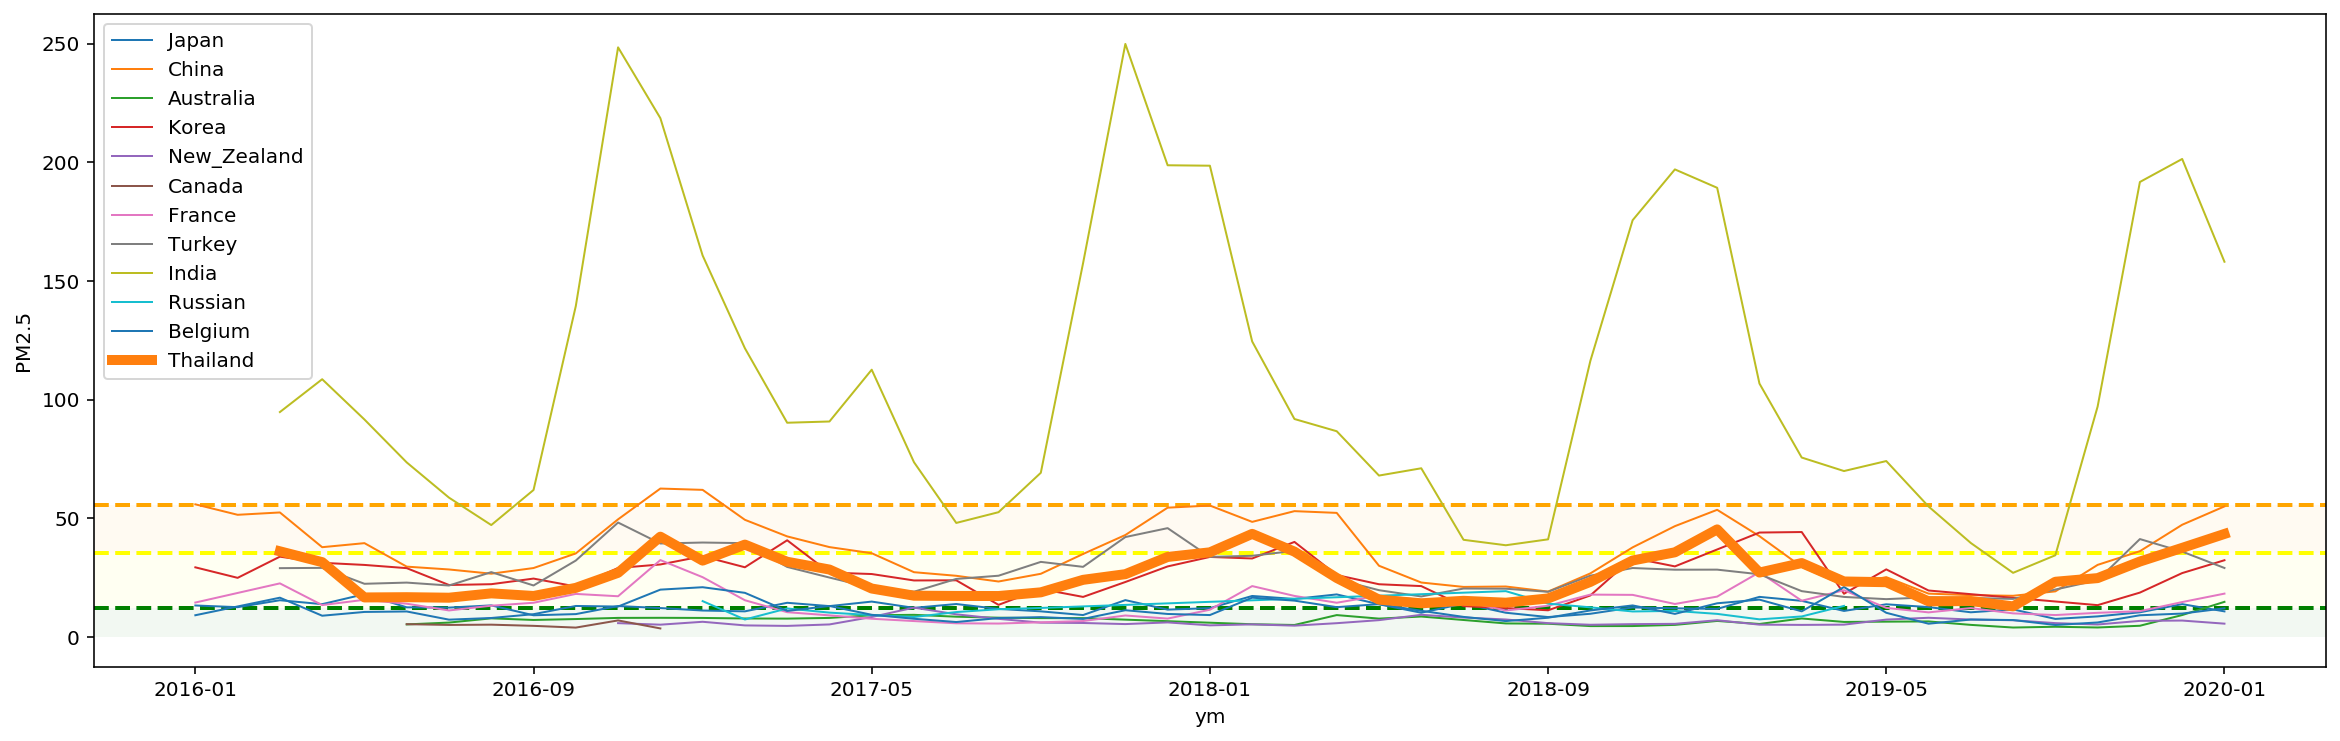

In [9]:
list_country = ['Japan','China','Australia','Korea','New_Zealand',
                'Canada','France','Turkey','India','Russian','Belgium']

plt.figure(figsize=(20, 6))    

#สร้างเส้นแบ่งระดับความอันตรายของค่าฝุ่น PM 2.5
create_level_PM25(3)

#การใช้ fuction ที่สร้างไว้ในการสร้างกราฟเส้นตรงแบบรันลูปประเทศที่อยู่ใน list_country โดยดึงข้อมูลจาก data_PM
plot_line_graph(data_PM,list_country,'ym','PM2.5',1,7)
#การใช้ fuction ที่สร้างไว้ในการสร้างกราฟเส้นตรงของประเทศไทย โดยกำหนดให้เส้นหนากว่าประเทศฮื่น
plot_line_graph(data_PM,['Thailand'],'ym','PM2.5',5,7)


- จากข่าวที่เกี่ยวข้องกับ PM(Partical Matter)2.5 ที่เราได้ศึกษามา เราได้เล็งเห็นว่าปัญหาของฝุ่นPM2.5นั้นไม่ได้เกิดขึ้นแค่ที่ประเทศไทยเพียงประเทศเดียว ดังนั้นเราจึงลองดึงข้อมูลฝุ่นจากประเทศอื่นมาศึกษา เราจึงดึงข้อมูลออกมาทำตารางเพื่อเปรียบเทียบค่าฝุ่นของกรุงเทพมหานคร(ประเทศไทย) กับเมืองหลวงในต่างประเทศทั่วทุกมุมโลกดู ผลปรากฏออกมาดังที่เห็นในกราฟ นี่คือข้อมูลฝุ่นตั้งแต่ปี 2016-ปัจจุบัน จะสั่งเกตได้ว่ามีเมืองหลวงของประเทศหนึ่งที่มีค่าฝุ่นเยอะมหาศาลจนทำให้ข้อมูลของประเทศอื่นทั้งหมดดูต่ำไปทั้งหมดเลย ประเทศนั้นก็คือ India นั่นเองส่วนสาเหตุนั้นน่าจะเกิดจากรถจำนวนมากและสภาพภูมิอากาศในประเทศที่แห้งก่อให้เกิดการรวมตัวของฝุ่นง่ายนั่นเอง 

# ตัดข้อมูลประเทศที่เป็น out liner 
- ตัดข้อมูลประเทศอินเดีย

In [10]:
ez = widgets.SelectMultiple(
    options=['Japan','China','Australia','Korea','New_Zealand','Canada',
                'France','Turkey','Russian','Belgium'],
    value=['Japan'],
    rows= 10,
    description='Countries',
    disabled=False
)
display(ez)

SelectMultiple(description='Countries', index=(0,), options=('Japan', 'China', 'Australia', 'Korea', 'New_Zeal…

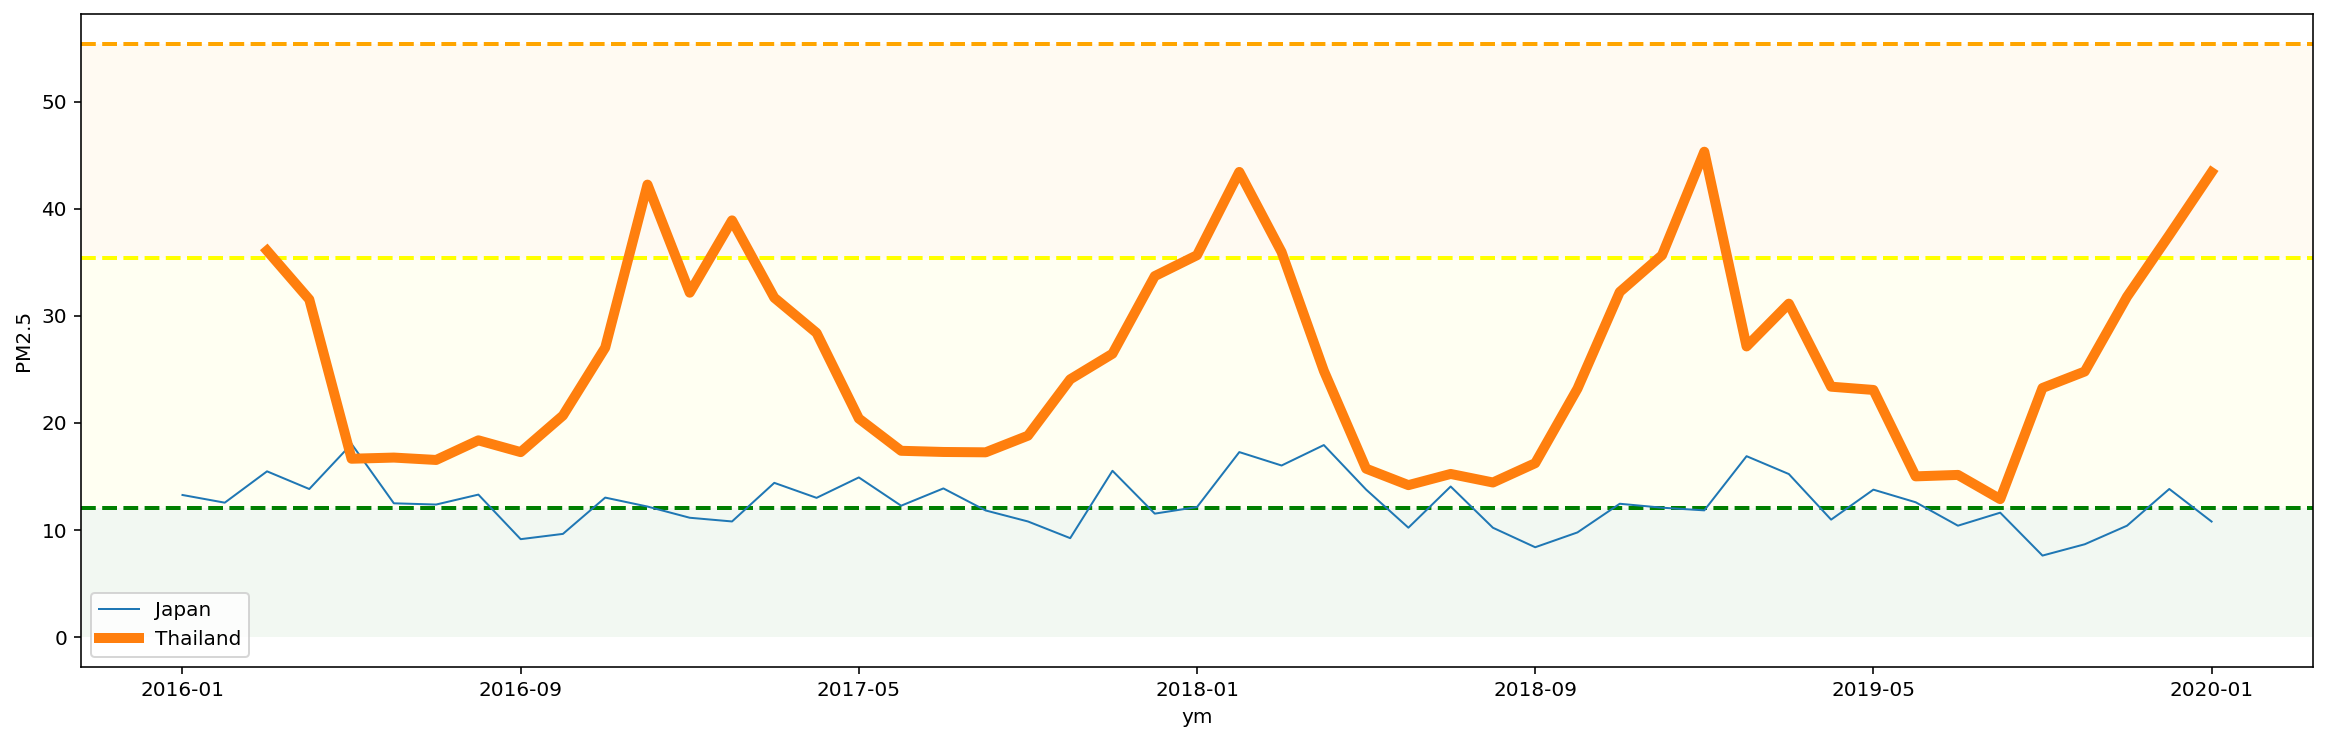

In [11]:
list_country = ez.value

plt.figure(figsize=(20, 6))    

#สร้างเส้นแบ่งระดับความอันตรายของค่าฝุ่น PM 2.5
create_level_PM25(3)

#สร้างกราฟแบบรันลูปประเทศที่อยู่ใน list_country โดยดึงข้อมูลจาก data_PM
plot_line_graph(data_PM,list_country,'ym','PM2.5',1,7)
#สร้างกราฟแบบรันลูปประเทศไทย โดยดึงข้อมูลจาก data_PM กำหนดให้เส้นหนากว่าประเทศอื่น
plot_line_graph(data_PM,['Thailand'],'ym','PM2.5',5,7)


- เมื่อข้อมูลของประเทศอินเดียมีค่าสูงเกินไปจึงทำให้เกิดความไม่สมดุลของกราฟและทำให้ศึกษาข้อมูลได้ยาก เราจึงจำเป็นต้องตัด outliner 
อย่างประเทศอินเดียออกไปเพื่อที่จะสามารถศึกษาข้อมูลได้ง่ายขึ้นดังกราฟที่ปรากฏด้านบน เส้นของประเทศไทยจะมีความหนาเป็นพิเศษ
เพื่อให้ง่ายแก่การเปรียบเทียบและศึกษา ทำให้เราได้เห็นว่าแม้แต่ประเทศที่พัฒนาแล้วบางประเทศก็ยังเกิดปัญหาฝุ่นเหมือนกัน หรือแม้แต่บางประเทศที่
อากาศบริสุทธิมากจนน่าตกใจ และนอกจากนี้เท่าที่เราสังเกตได้จะมีเมืองหลวงบางประเทศที่มีลักษณะหรือวัฏจักรการเกิดฝุ่นคล้ายหรือใกล้เคียงกับเราอยู่ไม่กี่ประเทศ


# เปรียบเทียบประเทศที่ pattern ค่าฝุ่น PM2.5 เหมือนประเทศไทย
- ได้แก่ ไทย จีน เกาหลี

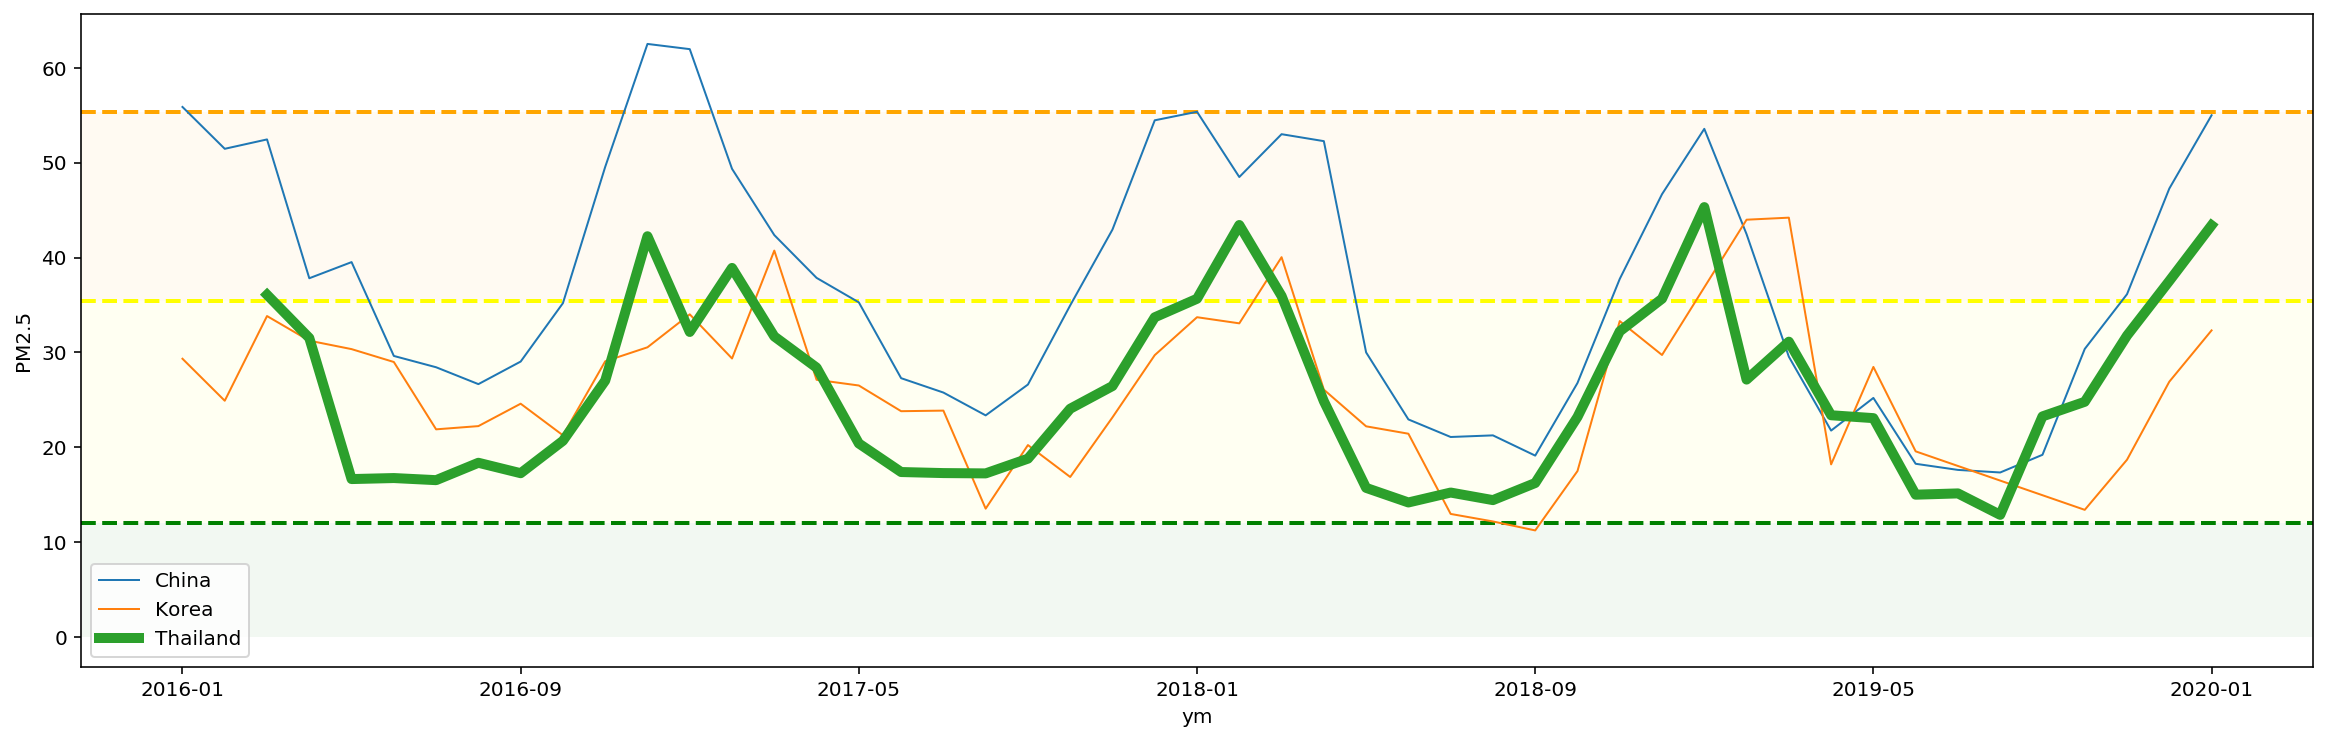

In [12]:
list_country = ['China','Korea']

plt.figure(figsize=(20, 6))    

#สร้างเส้นแบ่งระดับความอันตรายของค่าฝุ่น PM 2.5
create_level_PM25(3)

#สร้างกราฟแบบรันลูปประเทศที่อยู่ใน list_country โดยดึงข้อมูลจาก data_PM 
plot_line_graph(data_PM,list_country,'ym','PM2.5',1,7)
#สร้างกราฟแบบรันลูปประเทศไทย โดยดึงข้อมูลจาก data_PM กำหนดให้เส้นหนากว่าประเทศอื่น
plot_line_graph(data_PM,['Thailand'],'ym','PM2.5',5,7)


- เมื่อสังเกตดูแล้วลองตัดประเทศที่มีลักษณะการเกิดฝุ่นPM2.5 ไม่คล้ายหรือไม่ใกล้เคียงประเทศเราออกไป ก็จะเหลือเพียงแค่สองประเทศนั่นก็คือประเทศจีนและประเทศเกาหลีนั่นเอง สังเกตได้จากกราฟด้านบนว่าทั้งสามประเทศนี้มีการก่อตัวขึ้นของฝุ่นในเวลาที่พร้อมหรือใกล้เคียงกันเป็นอย่างมากคือในช่วงปลายปีหรือประมาณเดือน1,2และ12 เราจึงคิดว่าเมืองหลวงในประเทศทั้งสามนั้นมีสภาพภูมิอากาศที่คล้ายเคียงกันแถมยังอยู่ในภูมิภาคเอเชียเหมือนกัน ทำให้พวกเราคาดว่าข้อมูลที่เราสามารถวิเคราะห์ได้จากกรุงเทพมหานครก็สามารถใช้กับกรุงปักกิ่งและกรุงโซลได้เช่นกัน 

# ถึงพื้นที่จะต่างกัน แต่เหตุผลที่แต่ละประเทศมี pattern ค่าฝุ่นเหมือนกันคืออะไร?
- ทำการทดสอบตัวแปรสภาพอากาศของแต่ละประเทศ

In [13]:
data_correlation = {}

## เชื่อมตารางค่าฝุ่นPM2.5และค่าสภาพภูมิอากาศของกรุงเทพ ประเทศไทย

In [14]:
Thailand = data_PM['Thailand'].reset_index()[['Date','PM2.5']].merge(data_weather['th_weather'].reset_index()[['Date','Temperature','Humidity','Wind Speed']],how='inner',on='Date',)
data_correlation.update({'Thailand':Thailand})
Thailand

,Date,PM2.5,Temperature,Humidity,Wind Speed
0,2016-03-03,47.255556,84.7,51.2,4.8
1,2016-03-04,37.508696,85.2,70.8,6.8
2,2016-03-05,32.912500,85.7,72.3,8.1
3,2016-03-06,28.991667,86.0,72.6,8.2
4,2016-03-07,29.650000,87.2,72.5,8.5
...,...,...,...,...,...
1324,2020-01-22,40.854167,85.0,74.8,3.8
1325,2020-01-23,39.629167,85.4,73.3,6.8
1326,2020-01-24,28.200000,85.3,74.2,8.4
1327,2020-01-25,20.385714,84.6,73.5,11.1


## เชื่อมตารางค่าฝุ่นPM2.5และค่าสภาพภูมิอากาศของเมืองปักกิ่ง ประเทศจีน

In [15]:
China = data_PM['China'].reset_index()[['Date','PM2.5']].merge(data_weather['cn_weather'].reset_index()[['Date','Temperature','Humidity','Wind Speed']],how='inner',on='Date',)
data_correlation.update({'China':China})
China

,Date,PM2.5,Temperature,Humidity,Wind Speed
0,2016-01-01,69.987500,30.5,62.5,2.3
1,2016-01-02,74.997917,32.4,68.0,2.8
2,2016-01-03,83.063750,30.8,79.8,4.1
3,2016-01-04,77.035833,31.1,37.4,7.5
4,2016-01-05,62.509583,26.6,30.3,4.5
...,...,...,...,...,...
1371,2020-01-22,56.011818,29.3,54.5,2.0
1372,2020-01-23,55.535417,30.0,55.5,3.8
1373,2020-01-24,49.453750,31.3,50.5,4.5
1374,2020-01-25,72.847500,27.5,65.0,2.0


## เชื่อมตารางค่าฝุ่นPM2.5และค่าสภาพภูมิอากาศของเมืองโซล ประเทศเกาหลีใต้

In [16]:
Korea = data_PM['Korea'].reset_index()[['Date','PM2.5']].merge(data_weather['ko_weather'].reset_index()[['Date','Temperature','Humidity','Wind Speed']],how='inner',on='Date',)
data_correlation.update({'Korea':Korea})
Korea

,Date,PM2.5,Temperature,Humidity,Wind Speed
0,2016-01-01,56.212500,32.9,71.0,4.0
1,2016-01-02,29.383333,42.4,70.1,6.6
2,2016-01-03,41.529167,41.3,84.3,2.6
3,2016-01-04,75.675000,35.9,53.3,7.8
4,2016-01-05,14.520833,27.5,35.5,6.8
...,...,...,...,...,...
1280,2020-01-22,27.712500,35.3,59.7,3.2
1281,2020-01-23,39.660870,38.0,67.1,6.3
1282,2020-01-24,51.260870,34.8,76.7,5.4
1283,2020-01-25,39.530769,35.8,77.1,4.5


# Correlation Heatmap

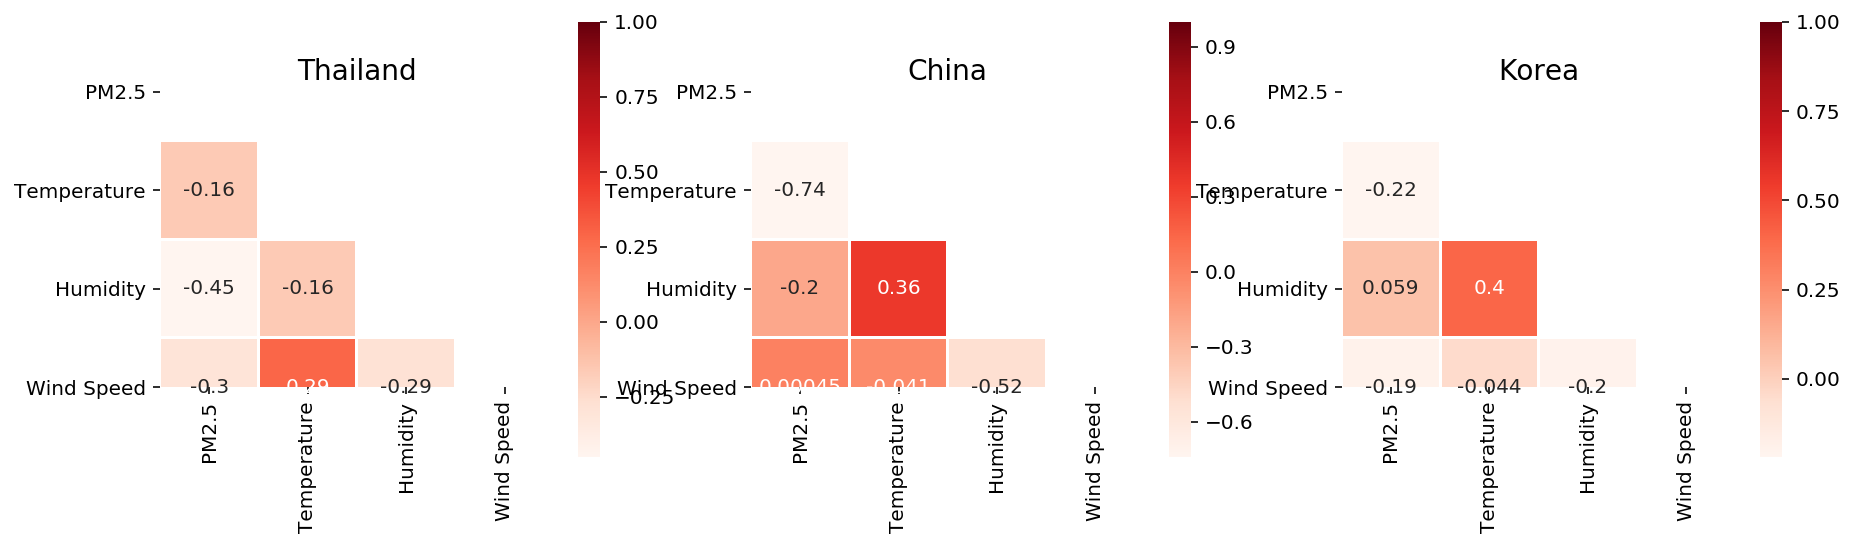

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))
#ทำการรันข้อมูลจาก data_correlation ที่เป็น dictionary ที่เก็บข้อมูลค่าฝุ่นและค่าสภาพอากาศของแต่ละประเทศ
for i,j in zip(data_correlation,range(3)):
    #ทำการคิดค่า correlation ของทั้ง df
    df = data_correlation[i][['PM2.5','Temperature', 'Humidity', 'Wind Speed']].corr()
    #กำหนด format ของ df
    df.style.format('{:.2f}').background_gradient(cmap='Blues')
    #การกำหนดให้ไม่่ขึ้น heatmap ที่มัน duplicate ข้อมูล
    mask=np.zeros_like(df)
    mask[np.triu_indices_from(mask)]=True
    #ทำการสร้าง heatmap ของค่า correlation ของ df
    sns.heatmap(df, cmap='Reds', annot=True, mask=mask, linewidths=1, ax=axes[j], square=True).set_title(i, fontsize=14)


# Temperature

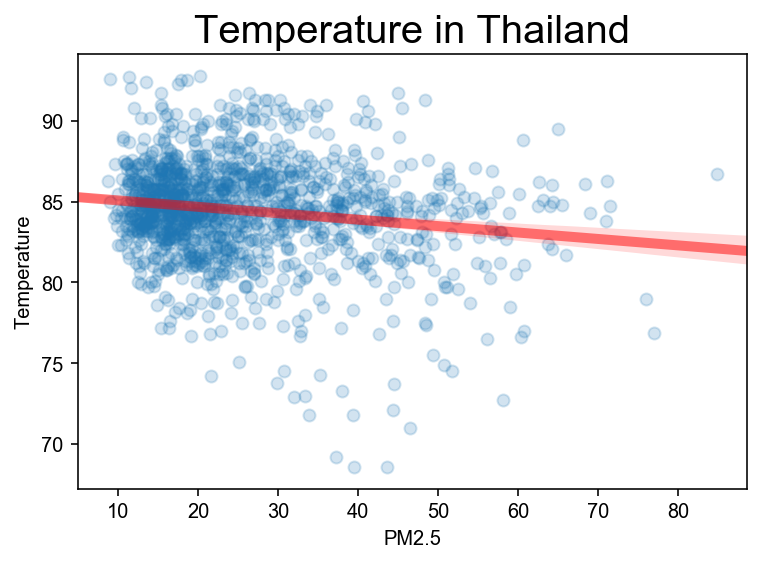

-.01 to -.19 : No or negligible relationship



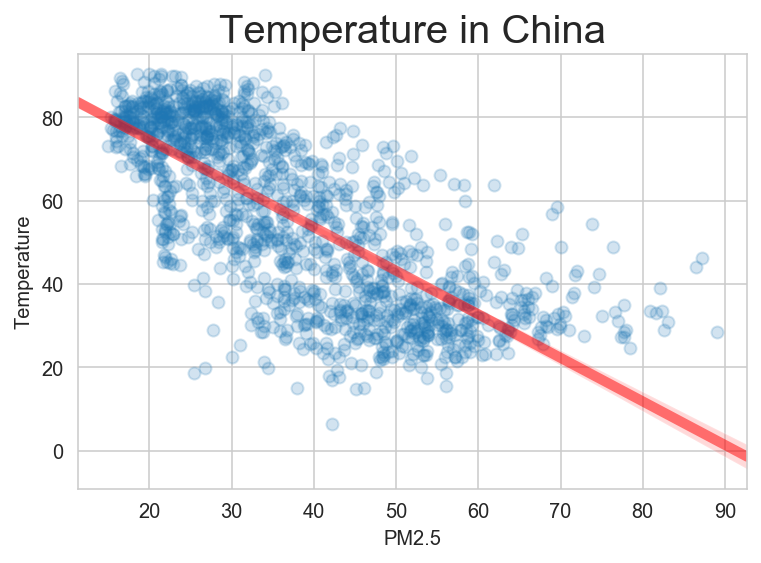

-.70 or higher : Very strong negative relationship



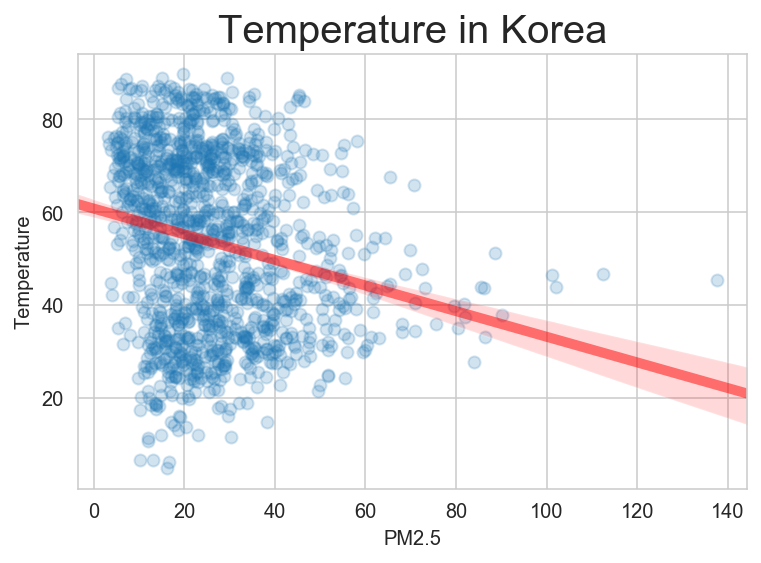

-.20 to -.29 : weak negative relationship



In [18]:
for i,j in zip(range(3),data_correlation):
    #สร้างกราฟ regression
    sns.regplot(x=data_correlation[j]['PM2.5'], y=data_correlation[j]['Temperature'], 
                line_kws={"color":"r","alpha":0.5,"lw":5},scatter_kws={"alpha":0.2})
    #ตั้งชื่อกราฟและกำหนดสไตล์
    plt.title(f'Temperature in {j}', fontsize = 20)
    sns.set_style("whitegrid")
    plt.show()

    #เช็ค correlation ระหว่าง 2 column (ค่าฝุ่นและอุณหภูมิ)
    corr = data_correlation[j]['PM2.5'].corr(data_correlation[j]['Temperature'])
    #เช็คความหมายของค่า correlation
    check_correlation_value(corr)
    print('')


# Humidity

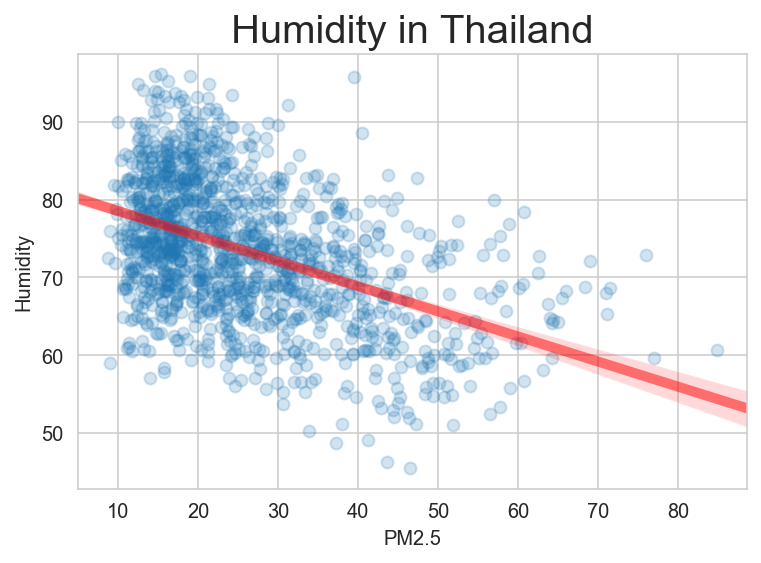

-.40 to -.69 : Strong negative relationship



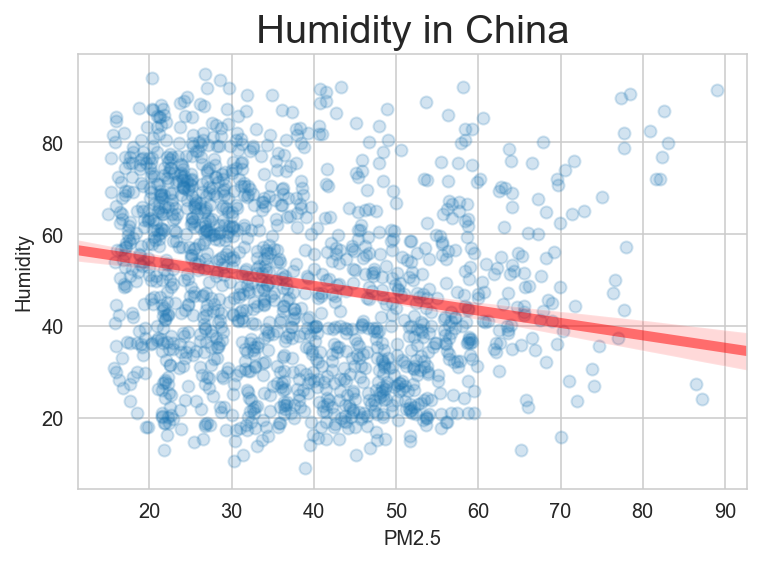

-.20 to -.29 : weak negative relationship



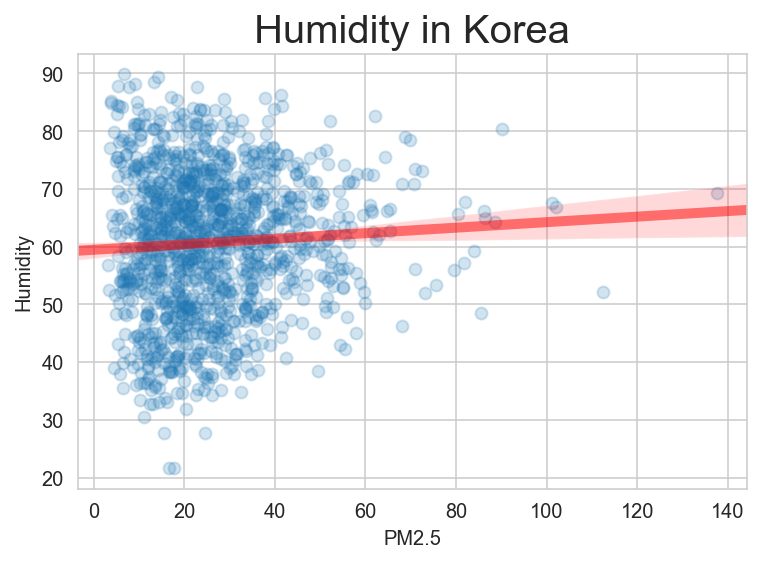

+.01 to +.19 : No or negligible relationship



In [19]:
for i,j in zip(range(3),data_correlation):
    #สร้างกราฟ regression
    sns.regplot(x=data_correlation[j]['PM2.5'], y=data_correlation[j]['Humidity'], 
                line_kws={"color":"r","alpha":0.5,"lw":5},scatter_kws={"alpha":0.2})
    #ตั้งชื่อกราฟและกำหนดสไตล์
    plt.title(f'Humidity in {j}', fontsize = 20)
    sns.set_style("whitegrid")
    plt.show()

    #เช็ค correlation ระหว่าง 2 column (ค่าฝุ่นและความชื้น)
    corr = data_correlation[j]['PM2.5'].corr(data_correlation[j]['Humidity'])
    #เช็คความหมายของค่า correlation
    check_correlation_value(corr)
    print('')


# Wind Speed

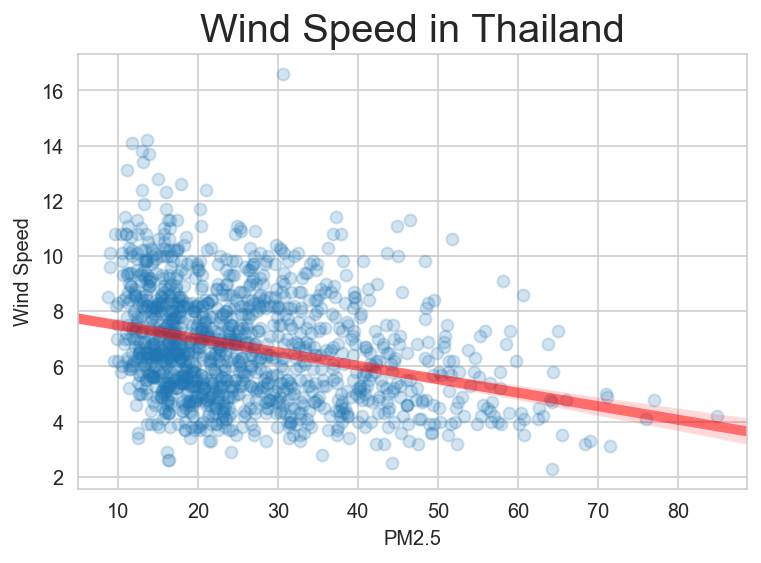

-.30 to -.39 : Moderate negative relationship



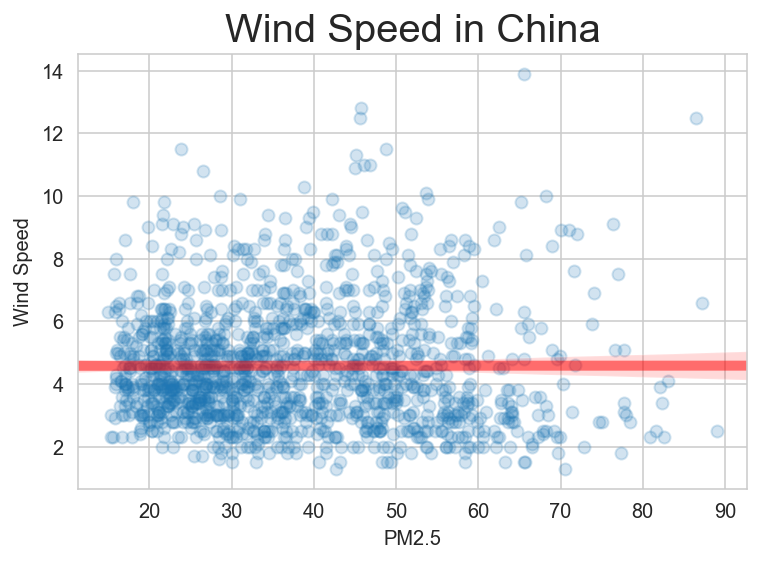

-.01 to -.19 : No or negligible relationship



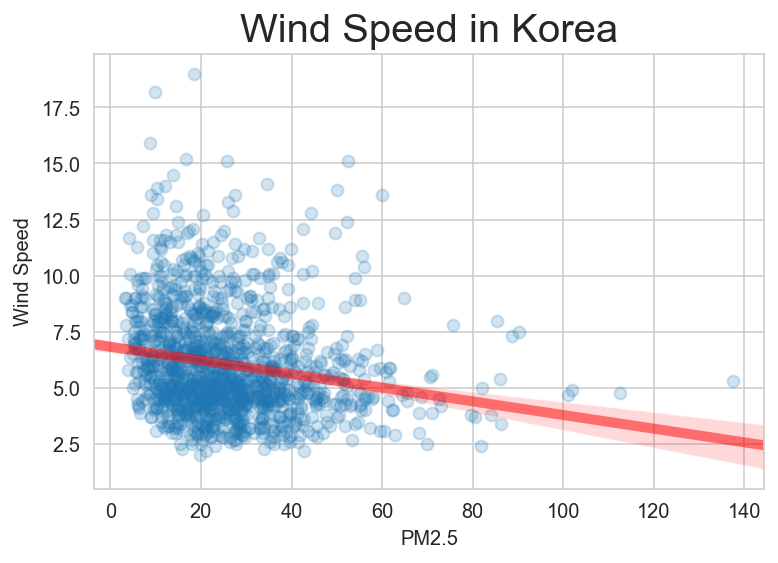

-.01 to -.19 : No or negligible relationship



In [20]:
for i,j in zip(range(3),data_correlation):
    #สร้างกราฟ regression
    sns.regplot(x=data_correlation[j]['PM2.5'], y=data_correlation[j]['Wind Speed'], 
                line_kws={"color":"r","alpha":0.5,"lw":5},scatter_kws={"alpha":0.2})
    #ตั้งชื่อกราฟและกำหนดสไตล์
    plt.title(f'Wind Speed in {j}', fontsize = 20)
    sns.set_style("whitegrid")
    plt.show()

    #เช็ค correlation ระหว่าง 2 column (ค่าฝุ่นและแรงลม)
    corr = data_correlation[j]['PM2.5'].corr(data_correlation[j]['Wind Speed'])
    #เช็คความหมายของค่า correlation
    check_correlation_value(corr)
    print('')


- เนื่องจากปัญหาฝุ่นPM2.5 ค่อนข้างเป็นปัญหารอบตัวจึงทำให้เกิดข้อสงสัยต่างๆนาๆว่าสาเหตุนั้นเกิดมาจากอะไรกันแน่ แน่นอนว่ามันคือฝีมือมนุษย์อย่างไม่ต้องสงสัย เราไม่อาจโทษธรรมชาติในเรื่องนี้ได้เลย แต่ข้อมูลที่เราจะศึกษาในวันนี้ก็คือธรรมชาตินั้นมีส่วนที่ทำให้ค่าฝุ่นในพื้นที่มีค่าเพิ่มขึ้นหรือลดลงหรือป่าว พวกเราจึงนำข้อมูลอุณหภูมิ ความชื้น และแรงลมมา คิดหาผลว่าสภาพภูมิอากาศในแต่ละช่วงของปีนั้นส่งผลอะไรต่อค่าฝุ่นที่เพิ่มขึ้นหรือลดลงอย่างไรบ้าง ซึ่งก็ออกมาตามที่เห็นในกราฟและค่าสหสัมพันธ์(Correlation) ค่าอุณหภูมิ(Temperature)ไม่มีความเกี่ยวพันใดๆกับค่าฝุ่นเลย ซึ่งผิดกับค่าความชื้นในอากาศ(Humidity)ที่มีค่าแปรผกผันกับค่าฝุ่นPM2.5อย่างเห็นได้ค่อนข้างชัดเจน ซึ่งก็หมายความว่า เมื่อมีความชื้นในอากาศมากหรือถ้าเกิดฝนตก(ในหน้าฝน)ก็จะทำให้ค่าฝุ่นในอากาศลดลงอย่างเห็นได้ชัดผิดกับตอนที่อากาศแห้งในหน้าหนาวซึ่งค่าฝุ่นในช่วงเวลานี้มีจำนวนเพิ่มขึ้นอย่างเป็นนัยสำคัญ สุดท้ายคือค่าความเร็วลม(Windspeed)ที่ให้ค่าอย่างเป็นนัยๆว่าอาจจะมีค่าแปรผกผันกับค่าฝุ่นในอากาศ แต่ก็ไม่ได้เป็นปัจจัยที่สำคัญมากนัก ซึ่งเป็นเหตุผลที่สามารถเข้าใจได้ เนื่องจากเมื่อไม่มีลมฝุ่นที่ลอยตัวอยู่ในอากาศก็จะฝังตัวอยู่กับที่พื้นที่เดียวไม่กระจายออกไปไหนและทำใหเค่าฝุ่นมีจำนวนมากและหนาแน่น แต่หากมีแรงลมเข้ามาช่วยพัดฝุ่นก็จะทำให้ฝุ่นในอากาศกระจายตัวออกจากกันได้ดีและไม่ฝังลงในพื้นที่ๆเดียว สุดท้ายแม้ว่าธรรมชาติจะมีส่วนที่ทำให้ค่าฝุ่นลดลงไปบ้างแต่จริงๆแล้วจำนวนฝุ่นที่มากมายมหาศาลพวกนี้ก็เกิดขึ้นจากฝีมือของมนุษย์ในทุกวันอยู่ดี ไม่ว่าจะเป็นการใช้รถยนต์หรือการทำโรงงานอุตสาหกรรมต่างๆ เนื่องจากยังมีคนหลายกลุ่มที่ยังเข้าใจผิดว่าฝุ่นนั้นเป็นปรากฏการณ์ตามธรรมชาติซึ่งเกิดขึ้นมาตลอดทุกปีอยู่แล้ว(เมื่อมองจากกราฟ) แต่ความจริงธรรมชาติเป็นเพียงปัจจัยที่ทำให้ค่าฝุ่นที่มีอยู่ลดลงหรือชัดเจนขึ้นเท่านั้น

# ในเมื่อ PM2.5 เป็นปัจจัยที่ควบคุมได้ยาก จึงอยากรู้ว่าถ้าฝุ่นมีค่าสูงขึ้นจะส่งผลต่อร่างกายคนไหมเพราะถ้าไม่มีผล หรือมีผลน้อยเราอาจจะอยู่ร่วมกับมันได้โดยไม่ต้องป้องกันเลยก็ได้
- สาเหตุที่เราคิดว่าฝุ่นอันตรายกับร่างกายเราเพราะสื่อ อาทิเช่นมีคนใน social media มาโพสว่าตัวเองไอเป็นเลือดจากฝุ่น แต่ถ้าเราลองสังเกตดีๆมีเพียงไม่ถึง 10 คนจากคนไทย 69 ล้านคน จึงเป็นสาเหตุที่ทำให้เราสงสัยว่าฝุ่นมีผลต่อร่างกายขนาดนั้นจริงไหม หรือว่าแท้จริงแล้วคนไทยวิตกกันไปเองแบบที่รัฐบาลบอกจริงๆ
- โดยการหาค่าเฉลี่ยของ PM2.5 แต่ล่ะปีเพื่อดูแนวโน้มของฝุ่น
- หาคนป่วยที่เกี่ยวกับโรคทางเดินหายใจทั้งหมดในแต่ล่ะปี
- นำกราฟ2อันมาเทียบกันเพื่อดูแนวโน้มว่าไปทิศเดียวกันไหม

In [21]:
#ดึงค่าข้อมูลของประเทศไทยแล้วใช้ groupby เพื่อใช้หาค่าเฉลี่ยฝุ่น PM2.5 เฉพาะปีนั้นๆ
Thailandyear = Thailand.groupby(Thailand['Date'].dt.year)['PM2.5'].agg('mean')
Thailandyear

Date
2016    24.347414
2017    25.149736
2018    25.197866
2019    26.622393
2020    43.408082
Name: PM2.5, dtype: float64

In [22]:
#data source : http://statbbi.nso.go.th/staticreport/page/sector/th/05.aspx
#สร้าง columns สำหรับใส่ข้อมูลผู้ป่วยทางเดินหายใจที่ดึงมา
col_name = ('โรค','2016','2017','2018')
dw=pd.read_csv('https://www.dropbox.com/s/iywdzkwcafpe51n/people.csv?dl=1', skiprows=8, names = col_name,thousands=',')
dw

,โรค,2016,2017,2018
0,จำนวนผู้ป่วยทั้งหมดรวมจากโรคทางเดินหายใจรายปี,763833,743559,753281


In [23]:
#ทำข้อมูลให้เป็น long format โดยใช้ melt
res = pd.melt(dw, var_name=['Year'])
#เอาแค่ปี 2016-2018 
pat = res[1:4]
#เปลี่ยนชื่อเป็น number of patients
pat.rename(columns={'Year':'Date','value': 'number of patients'}, inplace=True)
pat

C:\Users\kantawanrojanasit\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,Date,number of patients
1,2016,763833
2,2017,743559
3,2018,753281


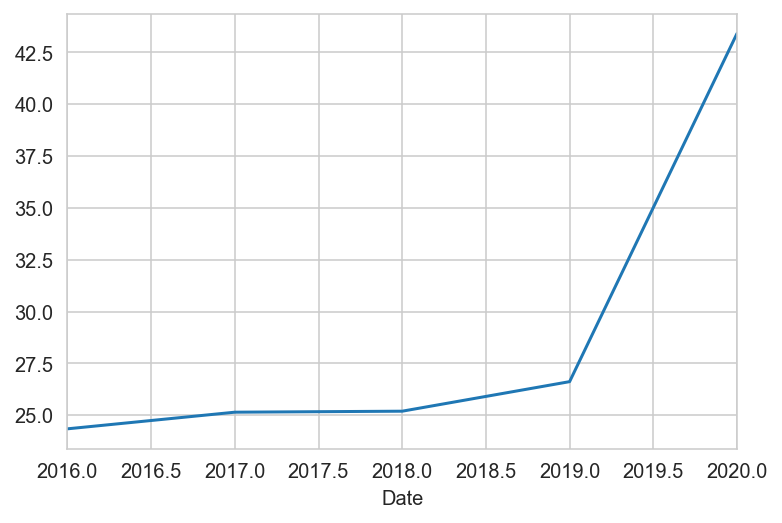

In [24]:
Thailandyear.plot(kind='line')

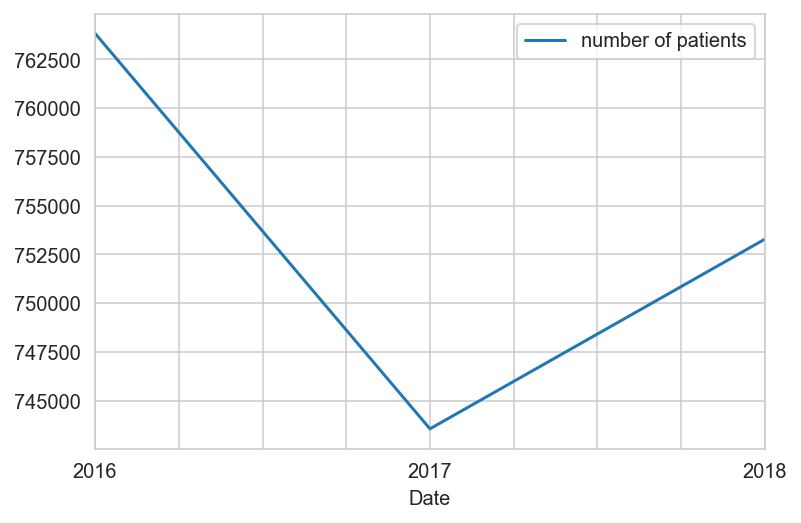

In [25]:
pat = pat.set_index('Date')
pat.plot(kind='line')

- จะเห็นได้กว่ากราฟ จำนวนผู้ป่วยโรคทางเดินหายใจและ ค่าเฉลี่ยฝุ่น PM2.5 มีทิศทางไม่คล้องกันเลย จึงอาจจะสรุปได้ว่า ฝุ่นอาจจะไม่ส่งผลอันตรายต่อร่างกายเรา หรืออาจเป็นเพราะปัจจัยอื่นเช่น เครื่องมือทางการแพทย์ดีขึ้น ต้องดูกันต่อไปจากข้อมูลในภายหน้า
- หมายเหตุ:เนื่องจากข้อมูลผู้ป้วยมีจำนวนปีที่บันทึกน้อยไป จีงไม่สามารถนำมาเทียบค่า correlation ได้เพราะจะทำให้เพี้ยน

- เมื่อพูดถึงฝุ่นแล้วก็ต้องพูดถึงโรคภัยต่างๆที่อาจจะเกิดขึ้นกับมนุษย์ ไม่ว่าจะเป็น โรคเกี่ยวกับทางเดินหายใจ การติดเชื้อของทางเดินหายใจส่วนบนแบบเฉียบพลัน โรคหลอดลมอักเสบ ถุงลมโป่งพองและปอดชนิดอุดกั้นแบบเรื้อรัง เป็นต้น ซึ่งเราได้นำข้อมูลของผู้ป่วยในโรคเหล่านี้มาได้ทั้งหมดสามปี เมื่อมาดูความเกี่ยวข้องทางข้อมูลและพิสูจน์ว่าค่าฝุ่นPM2.5ในอากาศนั้นส่งผลอันตรายกับมนุษย์อย่างเป็นนัยสำคัญ ซึ่งผลที่ปรากฏกลับตรงกันข้ามกับที่สันนิษฐาน ซึ่งข้อมูลแสดงให้เห็นว่าข้อมูลผู้ป่วย(เฉพาะโรคที่เกี่ยวกับทางเดินหายใจ)นั้นมีค่าแปรผกผันกับค่าฝุ่นPM2.5 ซึ่งก็หมายความว่าเมื่อค่าฝุ่นลดลงจำนวนคนป่วยจะเพิ่มมากขึ้น และเมื่อค่าฝุ่นมากขึ้นจำนวนคนป่วยจะน้อยลง ซึ่งเราไม่อาจคิดแบบนั้นได้แบบมั่นใจ เราคิดว่าน่าจะมีสาเหตุอื่นมากกว่าที่ส่งผลต่อการเกิดโรคเช่นบุหรี่หรือควันรถยนต์

# เปรียบเทียบค่าฝุ่นตอนที่ประเทศประเทศไทยมีค่ามาก

In [26]:
country_list = ['Japan','China','Australia','Korea','New_Zealand',
                'Canada','France','Turkey','India','Russian','Belgium']


def merge_df(data,key,first_df,first_name,x,y,how):
    #ทำการ merge fisrt_dfที่ต้องการให้อยู่ด้านซ้ายตาราง และ dfแรกที่อยู่ใน list ของ data
    df = first_df.reset_index()[[x,y]].merge(data[key[0]].reset_index()[[x,y]],how=how,on=x)
    df = df.rename(columns={'PM2.5_x':first_name, 'PM2.5_y':key[0]})

    #ทำการ merge df ตัวที่เหลือที่อยู่ใน list 
    for i in key[1:]:
        df = df.merge(data[i].reset_index()[[x,y]],how=how,on=x,suffixes=('','_y'))
        df = df.rename(columns={'PM2.5':i,'PM2.5_y':i})
    return df
        
data_PM_all_countrys = merge_df(data_PM,country_list,data_PM['Thailand'],'Thailand','Date','PM2.5','left')
data_PM_all_countrys

,Date,Thailand,Japan,China,Australia,Korea,New_Zealand,Canada,France,Turkey,India,Russian,Belgium
0,2016-03-03,47.255556,23.241935,52.553750,NaN,23.462500,NaN,NaN,NaN,26.394000,144.980000,NaN,6.548571
1,2016-03-04,37.508696,27.536170,58.722917,NaN,46.300000,NaN,NaN,NaN,19.895417,70.758333,NaN,8.632500
2,2016-03-05,32.912500,27.912500,70.048333,NaN,23.391667,NaN,NaN,NaN,18.869583,52.133333,NaN,16.318333
3,2016-03-06,28.991667,19.689583,74.667083,NaN,17.545833,NaN,NaN,NaN,24.410417,69.770833,NaN,9.612083
4,2016-03-07,29.650000,13.822917,71.982917,NaN,28.329167,NaN,NaN,11.470588,33.543043,97.887500,NaN,10.552500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,2020-01-22,40.854167,15.920833,56.011818,14.733750,27.712500,5.008333,NaN,28.720833,19.621250,194.641667,NaN,22.832083
1331,2020-01-23,39.629167,17.083333,55.535417,6.969583,39.660870,5.045833,NaN,26.095652,30.777083,70.608333,NaN,24.527500
1332,2020-01-24,28.200000,19.421739,49.453750,4.672917,51.260870,4.760870,NaN,36.731579,20.222857,70.477273,NaN,19.245000
1333,2020-01-25,20.385714,7.515385,72.847500,3.236923,39.530769,4.723077,NaN,53.666667,25.024000,130.713333,NaN,28.285333


- อย่างที่เราทราบกันว่าในเดือนที่1,2และ12 ของไทยเป็นช่วงที่มีค่าฝุ่นเยอะที่สุดในทุกๆปี เราจึงนำข้อมูลฝุ่นของกรุงเทพมหานครไปเปรียบเทียบกับเมืองหลวงต่างๆทั่วโลกว่าในช่วงที่กรุงเทพมหานครมีค่าฝุ่นเยอะนั้น แต่ละประเทศมีค่าฝุ่นเท่าไหร่กันบ้างซึ่งก็จะทำให้เราคิดได้ว่าเราสามารถนำข้อมูลดังเกล่ามาประยุกต์ใช้กับการท่องเที่ยวได้เช่น หาประเทศที่มีค่าฝุ่นน้อยๆตอนช่วงเดือนหน้าหนาวนี้แล้วจัดโปรโมชั่นทั่วพักผ่อนหนีฝุ่นได้ 

In [30]:
#นำ df ที่รวมทุกประเทศมากรุ๊ปด้วยเดือน ออกมาเป็นค่าเฉลี่ย
PM_groupby_month = data_PM_all_countrys.groupby(data_PM_all_countrys.Date.dt.strftime('%m')).mean()

#ทำ index เป็น column พร้อมเปลี่ยนชื่อคอลัมนั้น
PM_groupby_month = PM_groupby_month.reset_index().rename(columns=({'Date':'Month'}))

#unpivot dataframe 
PM_groupby_month = PM_groupby_month.melt(id_vars=['Month'],var_name='Country',value_name='PM2.5')
PM_groupby_month

,Month,Country,PM2.5
0,01,Thailand,38.973306
1,02,Thailand,37.445520
2,03,Thailand,33.582178
3,04,Thailand,27.477926
4,05,Thailand,18.895006
...,...,...,...
139,08,Belgium,7.350595
140,09,Belgium,7.875337
141,10,Belgium,9.592740
142,11,Belgium,11.623704


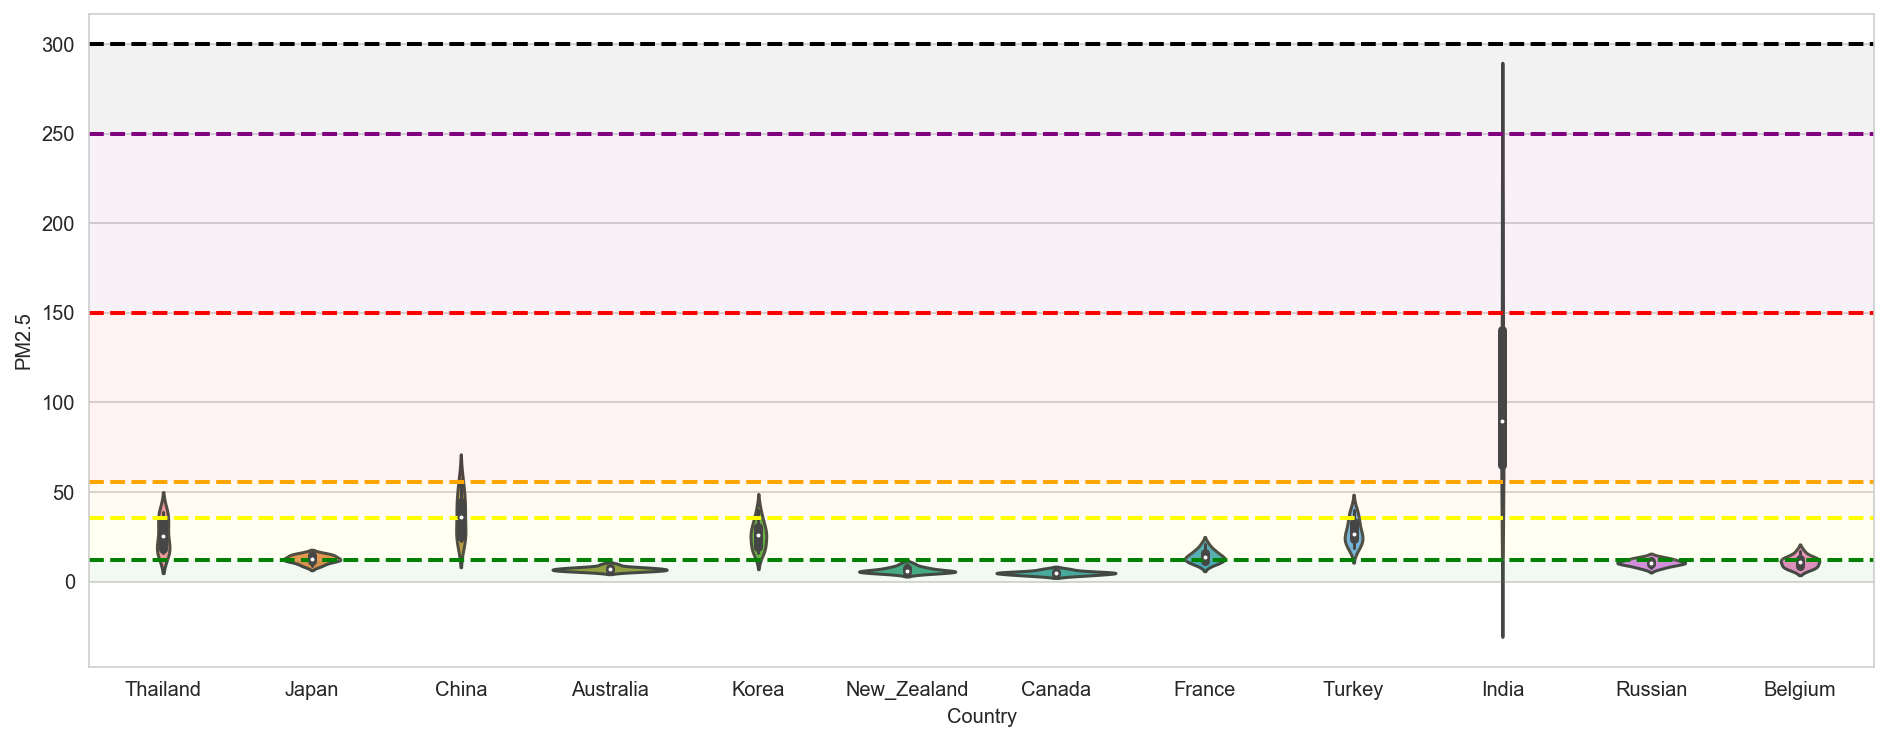

In [31]:
plt.figure(figsize=(16, 6))
graph2 = sns.violinplot(x='Country', y='PM2.5', data=PM_groupby_month, )

#สร้างเส้นแบ่งระดับความอันตรายของฝุ่น
create_level_PM25(6)

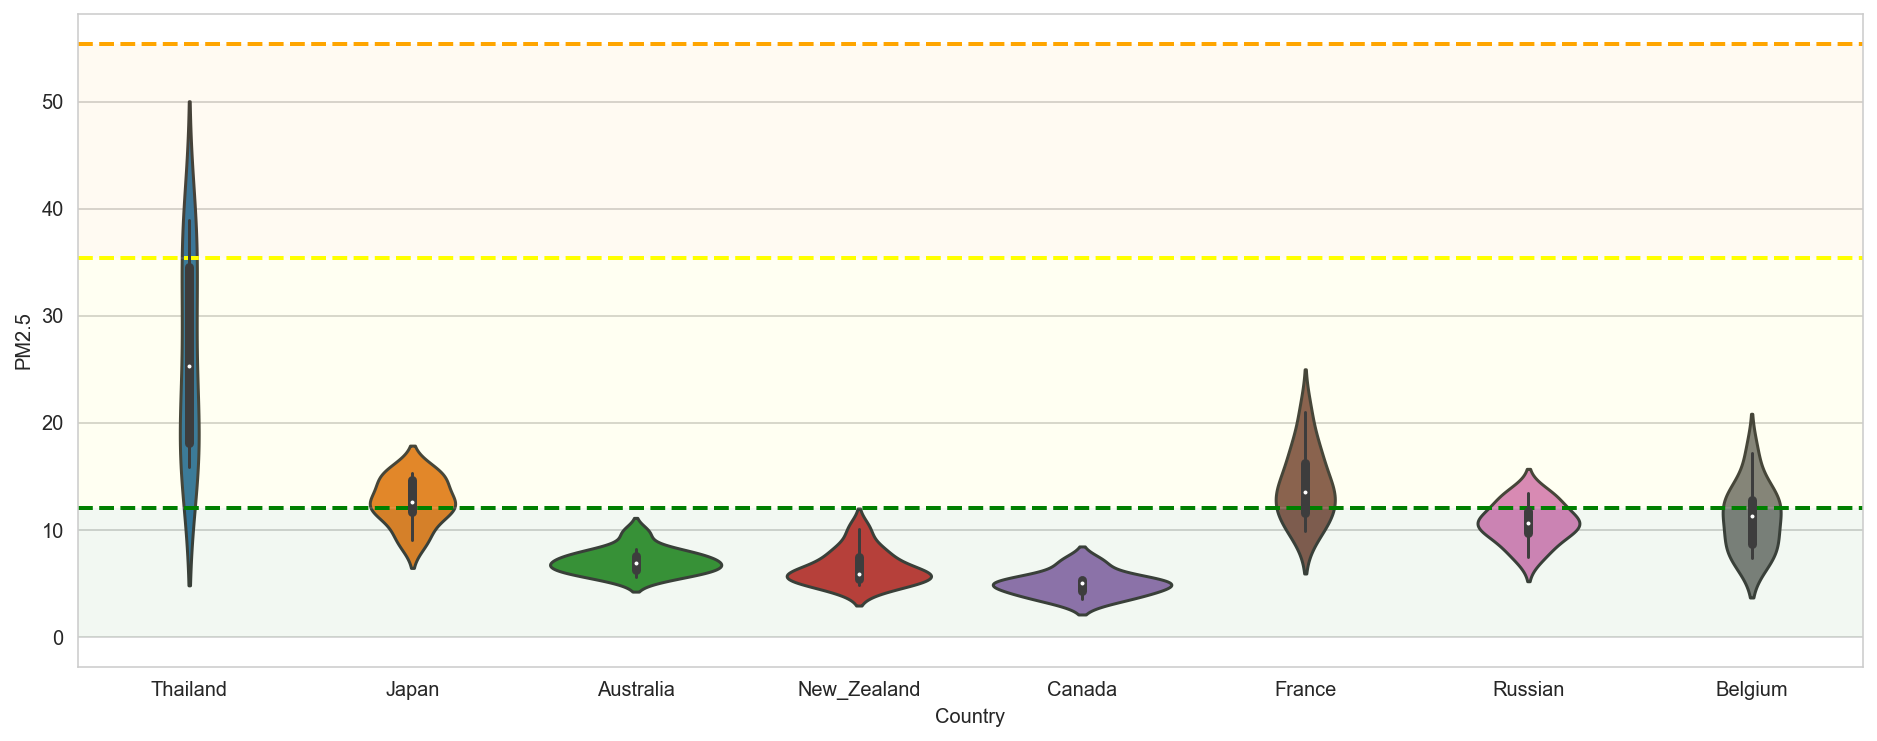

In [32]:
plt.figure(figsize=(16, 6))

#สร้างเส้นแบ่งระดับความอันตรายของฝุ่น
create_level_PM25(3)

#ตัดประเทศที่มีค่าฝุ่นสูงกว่าไทย 
graph2 = sns.violinplot(x='Country', y='PM2.5', data=PM_groupby_month[(PM_groupby_month['Country'] !='China')
                                                          &(PM_groupby_month['Country'] !='Korea')
                                                          &(PM_groupby_month['Country'] != 'India')
                                                          &(PM_groupby_month['Country'] != 'Turkey')] , )

- อย่างที่เห็นในแผนภาพแทบทุกเมืองหลวงที่อยู่ในแผนภาพมีจำนวนฝุ่นน้อยกว่าประเทศไทยอยู่มากพอสมควร มีเพียงแค่ จีนที่มีค่าฝุ่นมากกว่าไทยและ เกาหลีกับตุรกีที่มีค่าฝุ่นใกล้เคียงกับไทย ซึ่งหากเทียบกับบางประเทศเช่น NewZealand กับ Canada ซึ่งค่าฝุ่นอยู่ในเขตที่อากาศเกือบจะบริสุทธิ์ ซึ่งเหมาะแก่การไปท่องเที่ยวพักผ่อนเพื่อหนีฝุ่นในเมืองไทย สำหรับคนที่มีความกลัวเรื่องฝุ่น หรือแม้แต่คนที่มีโรคแพ้ฝุ่นโดยเฉพาะ